## **Charagement des bibliothèques**

In [210]:
import warnings
warnings.filterwarnings("ignore")
import time
import re
import os

import pandas as pd
import pandas.core.algorithms as algos
pd.set_option('display.max_rows',None) 
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import norm
from itertools import chain, combinations
import seaborn as sns

import joblib
import operator
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelBinarizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,RandomizedSearchCV,GridSearchCV,RepeatedKFold,cross_val_score
from sklearn.ensemble import ExtraTreesClassifier,ExtraTreesRegressor,AdaBoostRegressor,AdaBoostClassifier,RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor,GradientBoostingClassifier,BaggingClassifier,BaggingRegressor,VotingRegressor,VotingClassifier
from sklearn.metrics import mean_squared_error,roc_curve, auc,r2_score,accuracy_score,roc_auc_score,confusion_matrix,recall_score,classification_report,log_loss,make_scorer,precision_score,f1_score



In [211]:
def target_distribution(data,target):
    
    #construction table 
    
    endog = data[target]
    proportion = (data.groupby([target]).size())
    d1 = (((((data.groupby([target]).size()) / data.shape[0])*100).round(2)).to_frame("% of count")).astype("string")+"%"
    res = pd.concat([proportion.to_frame("Count"), d1],axis=1)
    xx = [c for c in res.index]
    value = [(c / res["Count"].sum())*100 for c in res["Count"]]
    with plt.style.context('seaborn-notebook'):
        plt.figure(figsize=(15,5))
        graph = plt.bar(xx,value,color="c")
        plt.title('Distribution de la Target', size=14,fontweight="bold")
        plt.ylabel("Frequence en (%)",fontweight="bold",size=12)
        plt.xlabel("Classe",fontweight="bold",size=12)
        plt.subplots_adjust(left=.3)
    
        i = 0
        for p in graph:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            plt.text(x+width*0.5,
                     y+height/3,
                     res["% of count"][i],
                     ha='center',
                     weight='bold')
            i+=1
        plt.show()

## **Chargement des donées**

In [212]:
bs = [c for c in os.listdir() if c.endswith(".csv")]
bs

['base_brut.csv', 'base_model_final.csv']

In [213]:
df = pd.read_csv('base_model_final.csv')

In [214]:
df.head()

,Score,lait,eau,arome,sel,naturel,acide,amidon,sucre,sodium,...,vegetale,huiledecolza,ecreme,huile,lecithine,lactique,citron,jus,riz,fruit
0,D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Distribution de la target

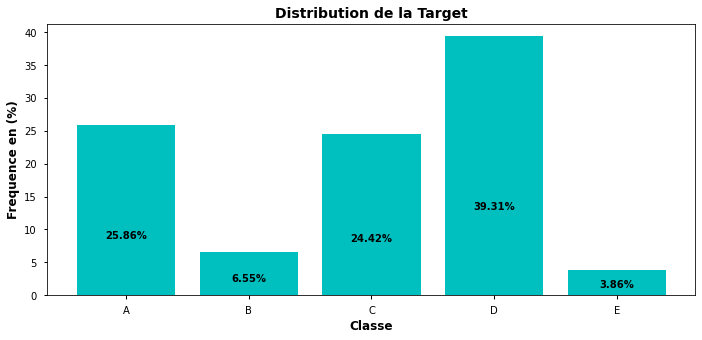

In [215]:
target_distribution(df,"Score")

## Pre-processing avant modélisation

In [216]:
y = df["Score"].copy()
X = df.drop("Score",axis=1)
encoding = {"E":0 ,"D":1 ,"C":2 ,"B":3 ,"A":4 }
y = y.apply(lambda x : encoding[x])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

## Construction du modèle

**Regression logistique multiclass**

In [217]:
lr = LogisticRegression(multi_class="multinomial",random_state=42,tol=1e-3)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)
space = dict()
space['solver'] = ['newton-cg','lbfgs','sag','saga'] # 'liblinear','newton-cg','lbfgs','sag','saga'
space['penalty'] = ['l2','none']
space['C'] = [10,100,0.1,0.01,0.001]
scoring = ['roc_auc']

In [218]:
%%time
search = GridSearchCV(lr, space, scoring ='roc_auc',n_jobs = -1, verbose = 2, cv=cv)
result = search.fit(X_train, y_train)

Fitting 6 folds for each of 40 candidates, totalling 240 fits
Wall time: 22.1 s


In [219]:
result.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

In [220]:
reg_log_select = result.best_estimator_
reg_log_select.fit(X_train, y_train)

LogisticRegression(C=10, multi_class='multinomial', random_state=42,
                   solver='newton-cg', tol=0.001)

In [222]:
y_pred = reg_log_select.predict(X_test)
y_pred_test = reg_log_select.predict_proba(X_test)
y_pred_train = reg_log_select.predict_proba(X_train)
_matrix = confusion_matrix(y_test, y_pred)
_matrix

array([[  0,  67,   0,   0,   0],
       [  0, 679,   5,   0,   1],
       [  0, 423,  14,   1,   4],
       [  0, 105,   0,   3,   0],
       [  0, 422,   2,   2,   7]], dtype=int64)

In [223]:
score_lr,auc_lr,gini_lr = [],[],[]

In [224]:
print("Score du modèle train : %.3f" % reg_log_select.score(X_train, y_train))
print("Score du modèle test : %.3f" % reg_log_select.score(X_test, y_test))
score_lr.append(reg_log_select.score(X_train, y_train))
score_lr.append(reg_log_select.score(X_test, y_test))

Score du modèle train : 0.406
Score du modèle test : 0.405


In [225]:
y_prob_pred = reg_log_select.predict_proba(X_test)

In [226]:
auc_train_lr = roc_auc_score(y_train,y_pred_train,multi_class="ovr").round(2)
auc_test_lr = roc_auc_score(y_test,y_pred_test,multi_class="ovr").round(2)
gini_train_lr = round(2*auc_train_lr - 1,2)
gini_test_lr = round(2*auc_test_lr - 1,2)

In [227]:
auc_lr.append(auc_train_lr)
gini_lr.append(gini_train_lr)
auc_lr.append(auc_test_lr)
gini_lr.append(gini_test_lr)

**XGBoost multiclass**

In [228]:
xgbc = xgb.XGBClassifier(learning_rate=0.5,
                    n_estimators=150,
                    max_depth=6,
                    min_child_weight=0,
                    gamma=0,
                    reg_lambda=1,
                    subsample=1,
                    colsample_bytree=0.75,
                    objective='multi:softprob',
                    num_class=5,
                    random_state=42)

mcl = xgbc.fit(X_train, y_train, eval_metric='mlogloss')
proba_test = mcl.predict_proba(X_test)
proba_train= mcl.predict_proba(X_train)

In [229]:
score_xgb,auc_xgb,gini_xgb = [],[],[]

In [230]:
print("Score du modèle train : %.3f" % mcl.score(X_train, y_train))
print("Score du modèle test : %.3f" % mcl.score(X_test, y_test))
score_xgb.append(mcl.score(X_train, y_train))
score_xgb.append(mcl.score(X_test, y_test))

Score du modèle train : 0.411
Score du modèle test : 0.409


In [231]:
auc_train_xgb = roc_auc_score(y_train,proba_train,multi_class="ovr").round(2)
auc_test_xgb = roc_auc_score(y_test,proba_test,multi_class="ovr").round(2)
gini_train_xgb = round(2*auc_train_xgb - 1,2)
gini_test_xgb = round(2*auc_test_xgb - 1,2)

In [232]:
auc_xgb.append(auc_train_xgb)
gini_xgb.append(gini_train_xgb)
auc_xgb.append(auc_test_xgb)
gini_xgb.append(gini_test_xgb)

In [233]:
resume = pd.DataFrame({"Score Logistic Regression":score_lr,"AUC Logistic Regression":auc_lr,"GINI Logistic Regression":gini_lr,
              "Score XGBoost":score_xgb,"AUC XGBoost":auc_xgb,"GINI XGBoost":gini_xgb})
resume.index = ["TRAIN","TEST"]

In [234]:
resume

,Score Logistic Regression,AUC Logistic Regression,GINI Logistic Regression,Score XGBoost,AUC XGBoost,GINI XGBoost
TRAIN,0.406474,0.53,0.06,0.411416,0.53,0.06
TEST,0.405187,0.52,0.04,0.408646,0.52,0.04
